<a href="https://colab.research.google.com/github/jgbrenner/psychometrics/blob/main/C9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Generating Psychometric Scale Items Measuring Perfectionism Using an Open Source LLM and Conducting Exploratory Graph Analysis**



# Methodology

# Overview

In this notebook, I will utilize an open-source large language model (LLM) to generate items for a psychometric scale measuring three dimensions of perfectionism: Rigid Perfectionism, Self-Critical Perfectionism, and Narcissistic Perfectionism. Following item generation, I will perform Exploratory Graph Analysis (EGA) to validate the structure and dimensionality of the generated items.


# Steps Involved

Item Generation:
I prompted the LLM to generate six items for each construct, specifying that five should be regular-keyed and one should be reverse-keyed. The output was formatted in JSON for easy processing.
The constructs targeted are:

- Rigid Perfectionism

- Self-Critical Perfectionism

- Narcissistic Perfectionism


# Data Preparation:

The generated items were compiled into a data frame, and constructs were extracted for further analysis.
An embeddings array was created to represent the items in a high-dimensional space suitable for EGA.

# Transfer to R:

The embeddings array and constructs list were transferred from Python to R using the rpy2 interface.

# Exploratory Graph Analysis (EGA):

In R, the embeddings array was converted into a matrix format, with appropriate row names assigned based on the constructs.
The EGAnet library was utilized to perform EGA on the embeddings matrix, allowing for an exploration of the underlying structure of the psychometric items.

Results were printed and visualized to assess the dimensionality of the constructs.

# Conclusion
This methodology enables a systematic approach to generating and validating psychometric scale items, ensuring that they are both relevant and statistically sound.

In [49]:
!pip install groq

In [50]:
# Load the R magic extension for rpy2
%load_ext rpy2.ipython

import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the path where the R library will be saved in Google Drive
library_path = '/content/drive/MyDrive/R_libraries'

# Create the directory if it doesn't exist
if not os.path.exists(library_path):
    os.makedirs(library_path)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Mounted at /content/drive


In [51]:
#verify rpy2 version as this is known to cause errors ( ver 3.4.2 works fine )
import rpy2
print(f"rpy2 version: {rpy2.__version__}")

rpy2 version: 3.4.2


In [53]:
%%R -i library_path

# Set the custom library path to persist during the Colab session
.libPaths(library_path)

# Set CRAN repository globally
options(repos = c(CRAN = "https://cloud.r-project.org"))

# List of required R packages
required_packages <- c("gmp", "Rmpfr", "CVXR", "fungible", "EGAnet")

# Install each package only if it's not already installed
for (pkg in required_packages) {
    if (!requireNamespace(pkg, quietly = TRUE)) {
        install.packages(pkg, lib = library_path, dependencies = TRUE)
    }
}

# Load EGAnet library
library(EGAnet)


In [54]:
# Import necessary Python libraries
import openai
import pandas as pd
import numpy as np
import json
import requests
import re


from google.colab import userdata

#fetching the OpenAI API key from secrets
openai_api_key = userdata.get('OPENAI_API_KEY')

from groq import Groq

#fetching the Groq API key from secrets
groq_api_key = userdata.get('GROQ_API_KEY')

# Initialize the Groq client
client = Groq(api_key=groq_api_key)

# Prompting is everything.

 Using the llama3-8b-8192 model  with this particualr prompt I was able to get the results needed. For other models the prompt might need to be modified, as all models are non-deterministic.

In [55]:
# Define the messages for the LLM
messages = [
    {
        "role": "system",
        "content": "You are an expert psychometrician creating test items."
    },
    {
        "role": "user",
        "content": (
            "Please generate six items for each of the following constructs: "
            "Self-Oriented Perfectionism: The tendency to demand perfection from oneself,"
            "Other-Oriented Perfectionism: Setting high expectations for others and critically evaluating their achievements,"
            "Socially Prescribed Perfectionism: The belief that others expect perfection from us. "
            "For each construct, provide six regular-keyed items "
            "Make them concise and clear. "
            "Provide the output ONLY in JSON format as a list of dictionaries, "
            "without any additional text or explanation. "
            "Each dictionary should have keys 'construct', 'item', and 'type' (either 'regular-keyed' or 'reverse-keyed')."
        )
    }
]

try:
    # Create the completion request
    completion = client.chat.completions.create(
        model="llama3-8b-8192", # using opensource model for replication purposes
        messages=messages,
        temperature=1,
        max_tokens=2048,
        top_p=1,
        stream=False,  # Disable streaming for simplicity
        stop=None,
    )

    # Collect the response content
    response_content = completion.choices[0].message.content
    print("\nLLM Output:\n", response_content)

except Exception as e:
    print(f"An error occurred: {e}")
    response_content = ""



LLM Output:
 [
  {
    "construct": "Self-Oriented Perfectionism",
    "item": "I have high standards for myself.",
    "type": "regular-keyed"
  },
  {
    "construct": "Self-Oriented Perfectionism",
    "item": "I demand a lot from myself.",
    "type": "regular-keyed"
  },
  {
    "construct": "Self-Oriented Perfectionism",
    "item": "I am never satisfied with my performance.",
    "type": "regular-keyed"
  },
  {
    "construct": "Self-Oriented Perfectionism",
    "item": "I set extremely high goals for myself.",
    "type": "regular-keyed"
  },
  {
    "construct": "Self-Oriented Perfectionism",
    "item": "I constantly strive to improve myself.",
    "type": "regular-keyed"
  },
  {
    "construct": "Self-Oriented Perfectionism",
    "item": "I am harder on myself than others.",
    "type": "regular-keyed"
  },
  {
    "construct": "Other-Oriented Perfectionism",
    "item": "I expect others to be more successful.",
    "type": "regular-keyed"
  },
  {
    "construct": "Other

In [56]:
# Parse the JSON response
try:
    generated_items = json.loads(response_content)
    items_df = pd.DataFrame(generated_items)
except json.JSONDecodeError as e:
    print(f"JSON decoding failed: {e}")
    # Attempt to extract JSON content from the response
    json_match = re.search(r'\[.*\]', response_content, re.DOTALL)
    if json_match:
        json_str = json_match.group(0)
        try:
            generated_items = json.loads(json_str)
            items_df = pd.DataFrame(generated_items)
        except json.JSONDecodeError as e2:
            print(f"Second JSON decoding attempt failed: {e2}")
            items_df = None
    else:
        print("No JSON content found in the response.")
        items_df = None

# Check if items_df is defined
if items_df is not None:
    # Save to CSV (optional)
    items_df.to_csv("perfectionism_items.csv", index=False)
    print("Items saved to 'perfectionism_items.csv'.")

    # Prepare the list of items
    item_texts = items_df["item"].tolist()

    # Ensure item_texts is clean and valid
    item_texts = [item for item in item_texts if item.strip()]  # Filter empty strings

    # Set up the API endpoint and headers for OpenAI embeddings
    embedding_endpoint = "https://api.openai.com/v1/embeddings"
    embedding_model = "text-embedding-3-small"  # Using a commonly available model

    headers = {
        "Authorization": f"Bearer {openai_api_key}",
        "Content-Type": "application/json"
    }

    # Prepare the data payload
    data = {
        "model": embedding_model,
        "input": item_texts
    }

    # Make the API request
    try:
        response = requests.post(embedding_endpoint, headers=headers, json=data)

        # Check if the request was successful
        if response.status_code != 200:
            print(f"Request failed with status code {response.status_code}: {response.text}")
        else:
            response_data = response.json()
            # Extract embeddings
            embeddings = [item['embedding'] for item in response_data['data']]
            embeddings_array = np.array(embeddings)
            print(f"Embeddings generated successfully. Shape: {embeddings_array.shape}")
            # Save the embeddings
            np.save("embeddings.npy", embeddings_array)
            print("Embeddings saved as 'embeddings.npy'.")
    except Exception as e:
        print(f"An error occurred during embedding generation: {e}")
else:
    print("Error: items_df is not defined. Cannot proceed with embedding generation.")



Items saved to 'perfectionism_items.csv'.
Embeddings generated successfully. Shape: (18, 1536)
Embeddings saved as 'embeddings.npy'.


In [57]:
# Prepare constructs list with unique item labels
items_df['item_label'] = items_df.apply(
    lambda row: f"{''.join([word[0] for word in row['construct'].split()])}{row.name+1}", axis=1
)
items_constructs = items_df['item_label'].tolist()


# Transfer data to R
%R -i embeddings_array -i items_constructs

In [58]:
%%R
# Convert embeddings_array to a matrix
embeddings_matrix <- as.matrix(embeddings_array)

# Assign row names to the matrix
rownames(embeddings_matrix) <- items_constructs

# Compute the correlation matrix between items
cor_matrix <- cor(t(embeddings_matrix))



Print correlation matrix heatmap

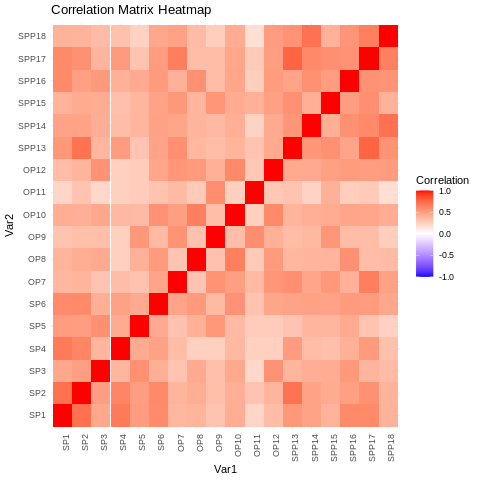

In [59]:
%%R

library(ggplot2)
library(reshape2)

# Melt the correlation matrix for plotting
heatmap_data <- melt(cor_matrix)

# Create a heatmap
ggplot(heatmap_data, aes(Var1, Var2, fill = value)) +
    geom_tile() +
    scale_fill_gradient2(low = "blue", high = "red", mid = "white", limit = c(-1, 1), name="Correlation") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = "Correlation Matrix Heatmap")

## **EGA result**

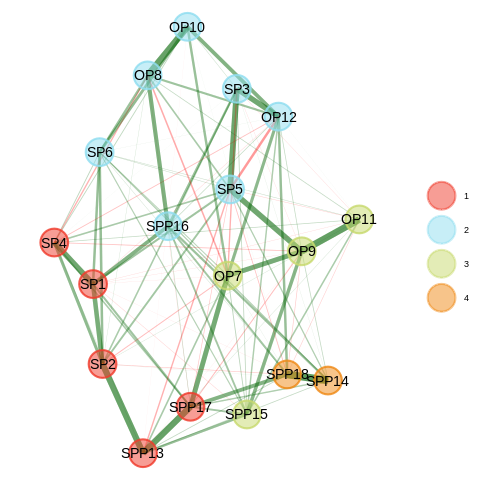

In [68]:
%%R

# Load EGAnet library
library(EGAnet)



# Perform EGA analysis with adjusted parameters
ega_result <- EGA(
    data = cor_matrix,
    n = 1000,                # Set a hypothetical sample size
    corr = "auto",           # Indicate that data is a correlation matrix
    model = "glasso",
    lambda.min.ratio = 0.01,    # Reduce lambda.min.ratio
    args.glasso = list(gamma = 0.5),  # Reduce gamma for sensitivity
    plot.EGA = TRUE,
    verbose = TRUE
)




In [69]:
%%R
print(cor_matrix)

            SP1       SP2       SP3       SP4       SP5       SP6       OP7
SP1   1.0000000 0.7102968 0.4494444 0.6699886 0.5085965 0.5895038 0.3761507
SP2   0.7102968 1.0000000 0.4987959 0.6219273 0.5056509 0.5955229 0.3890717
SP3   0.4494444 0.4987959 1.0000000 0.3819585 0.5683662 0.4170324 0.3055522
SP4   0.6699886 0.6219273 0.3819585 1.0000000 0.4358798 0.4830718 0.3463190
SP5   0.5085965 0.5056509 0.5683662 0.4358798 1.0000000 0.4400052 0.3173809
SP6   0.5895038 0.5955229 0.4170324 0.4830718 0.4400052 1.0000000 0.4700085
OP7   0.3761507 0.3890717 0.3055522 0.3463190 0.3173809 0.4700085 1.0000000
OP8   0.3899750 0.4257739 0.4402081 0.2486647 0.4040599 0.5205864 0.3052673
OP9   0.3075349 0.3356628 0.3326025 0.2446407 0.5362896 0.3612678 0.5553037
OP10  0.4210891 0.4161145 0.4512923 0.3631452 0.3596702 0.5571009 0.4968943
OP11  0.2173991 0.3057643 0.2017029 0.2505798 0.2664521 0.3112327 0.3598706
OP12  0.3411433 0.3887194 0.5557774 0.2485766 0.2652630 0.4660646 0.5381705
SPP13 0.5339

In [70]:
%%R

# Summary statistics of the correlation matrix
summary(cor_matrix)

      SP1              SP2              SP3              SP4        
 Min.   :0.2174   Min.   :0.3058   Min.   :0.2017   Min.   :0.2446  
 1st Qu.:0.3906   1st Qu.:0.3995   1st Qu.:0.3791   1st Qu.:0.3267  
 Median :0.4629   Median :0.4840   Median :0.4244   Median :0.3726  
 Mean   :0.4987   Mean   :0.5141   Mean   :0.4498   Mean   :0.4296  
 3rd Qu.:0.5941   3rd Qu.:0.5870   3rd Qu.:0.4869   3rd Qu.:0.5066  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
      SP5              SP6              OP7              OP8        
 Min.   :0.2385   Min.   :0.3112   Min.   :0.3053   Min.   :0.2487  
 1st Qu.:0.3098   1st Qu.:0.4586   1st Qu.:0.3639   1st Qu.:0.3453  
 Median :0.3933   Median :0.4803   Median :0.4669   Median :0.3887  
 Mean   :0.4256   Mean   :0.5072   Mean   :0.4765   Mean   :0.4393  
 3rd Qu.:0.4892   3rd Qu.:0.5194   3rd Qu.:0.5371   3rd Qu.:0.5001  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
      OP9              OP10       

In [71]:
%%R

pca_result <- prcomp(cor_matrix, scale. = TRUE)
summary(pca_result)


Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     2.2071 1.8866 1.7625 1.18677 1.11084 0.93250 0.89336
Proportion of Variance 0.2706 0.1977 0.1726 0.07825 0.06855 0.04831 0.04434
Cumulative Proportion  0.2706 0.4684 0.6410 0.71920 0.78775 0.83606 0.88040
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.71291 0.67641 0.61088 0.45048 0.41806 0.34369 0.32837
Proportion of Variance 0.02824 0.02542 0.02073 0.01127 0.00971 0.00656 0.00599
Cumulative Proportion  0.90863 0.93405 0.95478 0.96606 0.97577 0.98233 0.98832
                          PC15    PC16    PC17     PC18
Standard deviation     0.29497 0.28503 0.20498 2.98e-17
Proportion of Variance 0.00483 0.00451 0.00233 0.00e+00
Cumulative Proportion  0.99315 0.99767 1.00000 1.00e+00


In [72]:
%%R

high_correlations <- which(abs(cor_matrix) > 0.5 & lower.tri(cor_matrix), arr.ind = TRUE)
high_correlations_df <- as.data.frame(high_correlations)

# Display item pairs with high correlations
print(high_correlations_df)

        row col
SP2       2   1
SP4       4   1
SP5       5   1
SP6       6   1
SPP13    13   1
SPP16    16   1
SPP17    17   1
SP4.1     4   2
SP5.1     5   2
SP6.1     6   2
SPP13.1  13   2
SPP17.1  17   2
SP5.2     5   3
OP12     12   3
SPP16.1  16   3
SPP13.2  13   4
SPP17.2  17   4
OP9       9   5
OP8       8   6
OP10     10   6
SPP16.2  16   6
SPP17.3  17   6
OP9.1     9   7
OP12.1   12   7
SPP13.3  13   7
SPP15    15   7
SPP17.4  17   7
OP10.1   10   8
OP12.2   12   8
SPP16.3  16   8
OP11     11   9
SPP15.1  15   9
OP12.3   12  10
SPP16.4  16  12
SPP17.5  17  12
SPP18    18  12
SPP14    14  13
SPP15.2  15  13
SPP17.6  17  13
SPP18.1  18  13
SPP16.5  16  14
SPP17.7  17  14
SPP18.2  18  14
SPP16.6  16  15
SPP17.8  17  15
SPP17.9  17  16
SPP18.3  18  16
SPP18.4  18  17


# Translating to Polish

In [74]:
from openai import Client
import time
import pandas as pd

# Fetching the OpenAI API key from secrets
openai_api_key = userdata.get('OPENAI_API_KEY')

# Set the API key in the environment variable
os.environ["OPENAI_API_KEY"] = openai_api_key

# Initialize the OpenAI client
client = Client()

# Initialize the OpenAI client
client = Client()

# Function to translate text to Polish using OpenAI's GPT model
def translate_to_polish(text, model="gpt-4o-mini"):
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a professional psychologist and translator."},
                {"role": "user", "content": f"Translate the following text to Polish:\n\n{text}"}
            ],
            temperature=0.3,  # Lower temperature for more accurate translations
            max_tokens=100,    # Adjust based on the length of your items
        )
        # Accessing content correctly based on new structure
        translated_text = response.choices[0].message.content.strip()
        return translated_text
    except Exception as e:
        print(f"An error occurred during translation: {e}")
        return None

# Check if items_df exists and has the 'item' column
if 'items_df' in locals() and 'item' in items_df.columns:
    # Extract the English items
    english_items = items_df['item'].tolist()

    # Initialize a list to hold translated items
    translated_items = []

    for idx, item in enumerate(english_items):
        print(f"Translating item {idx+1}/{len(english_items)}: {item}")
        translation = translate_to_polish(item)
        if translation:
            translated_items.append(translation)
        else:
            translated_items.append("")  # Append empty string if translation failed

        time.sleep(1)  # Pause to respect API rate limits

    # Add the translated items to the dataframe
    items_df['item_pl'] = translated_items

    # Display the dataframe with translations
    display(items_df[['construct', 'item', 'item_pl']])

    # Optionally, save the translated items to a new CSV file
    items_df.to_csv("perfectionism_items_translated.csv", index=False)
    print("Translated items saved to 'perfectionism_items_translated.csv'.")
else:
    print("Error: 'items_df' dataframe with an 'item' column not found.")

Translating item 1/18: I have high standards for myself.
Translating item 2/18: I demand a lot from myself.
Translating item 3/18: I am never satisfied with my performance.
Translating item 4/18: I set extremely high goals for myself.
Translating item 5/18: I constantly strive to improve myself.
Translating item 6/18: I am harder on myself than others.
Translating item 7/18: I expect others to be more successful.
Translating item 8/18: I often find fault with others' work.
Translating item 9/18: Others should strive to do better.
Translating item 10/18: I am critical of others' achievements.
Translating item 11/18: Others could do more if they really tried.
Translating item 12/18: I am disappointed in others' performance.
Translating item 13/18: Others expect a lot from me.
Translating item 14/18: I feel pressure to be perfect because of others' expectations.
Translating item 15/18: Others think I should be doing better.
Translating item 16/18: I often feel that I'm not meeting others'

,construct,item,item_pl
0,Self-Oriented Perfectionism,I have high standards for myself.,Mam wysokie wymagania wobec siebie.
1,Self-Oriented Perfectionism,I demand a lot from myself.,Wymagam od siebie dużo.
2,Self-Oriented Perfectionism,I am never satisfied with my performance.,Nigdy nie jestem zadowolony ze swoich osiągnięć.
3,Self-Oriented Perfectionism,I set extremely high goals for myself.,Ustalam dla siebie niezwykle wysokie cele.
4,Self-Oriented Perfectionism,I constantly strive to improve myself.,Nieustannie dążę do samodoskonalenia.
5,Self-Oriented Perfectionism,I am harder on myself than others.,Jestem surowszy dla siebie niż dla innych.
6,Other-Oriented Perfectionism,I expect others to be more successful.,"Oczekuję, że inni będą bardziej sukcesywni."
7,Other-Oriented Perfectionism,I often find fault with others' work.,Często krytykuję pracę innych.
8,Other-Oriented Perfectionism,Others should strive to do better.,Inni powinni dążyć do lepszego.
9,Other-Oriented Perfectionism,I am critical of others' achievements.,Krytycznie oceniam osiągnięcia innych.


Translated items saved to 'perfectionism_items_translated.csv'.
